In [1]:
from notebook.services.config import ConfigManager
cm = ConfigManager()
cm.update('livereveal', {
        'width': '90%',
        'height': '90%',
        'scroll': True,
})

{'width': '90%', 'height': '90%', 'scroll': True}

# Who am I

- Jesse Grabowski
- Economist/Modeler at DEV, Country Diagnostics/MCDR
- Core Developer, PyMC / Pytensor
- Principal Data Scientist, PyMC Labs

https://github.com/jessegrabowski

https://www.linkedin.com/in/jessegrabowski/

www.jbgrabowski.com

https://discourse.pymc.io/

# What are we doing?

- Writing economic models is hard

- Writing performant code is hard

- Translating economic models into performant code is really hard!

Fortunately, more and more tools exist to help us. 

## Tools for fast code

- JIT compilers (NUMBA, JAX)
- Symbolic simplification (Sympy)
- Static graph optimization (Pytensor)

Let's look at all of these in turn.

## JIT compilation

You probably know that python is slow. What you might not know is that most python math libraries don't run in native python. Numpy, for example, uses highly optimized C code. For linear algebra operations, it calls out to BLAS, which uses FORTRAN or C (depending on your system)

In [2]:
def python_matmul(a, b):
    """
    Matrix multiplication in native python
    
    Totally unoptimized, not recommended.
    """
    a_rows = len(a)
    b_rows = len(b)
    a_cols = len(a[0])
    b_cols = len(b[0])
    assert a_cols == b_rows
        
    result = []
    for i in range(a_rows):
        row = []
        for j in range(b_cols):
            accumulator = 0
            for k in range(a_cols):
                accumulator += a[i][k] * b[k][j]
            row.append(accumulator)
        result.append(row)
    return result 

In [3]:
import numpy as np
x = np.random.normal(size=(10, 10))
y = np.random.normal(size=(10, 10))

py_matmul = %timeit -o python_matmul(x, y)
np_matmul = %timeit -o x @ y

print(f'numpy speedup vs python: {py_matmul.average / np_matmul.average: 0.2f}x')

275 μs ± 10.5 μs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)
715 ns ± 3.86 ns per loop (mean ± std. dev. of 7 runs, 1,000,000 loops each)
numpy speedup vs python:  384.27x


The numpy code is faster because it's pre-compiled. That's nice if we know ahead of time exactly what code we want, and we know how to write in a compiled language like C, FORTRAN, or Rust. If we do, we can use tools like `ctypes`, `f2py`, or `PyO3`. 

This is kind of a headache, though, because we have to deal with compilers and whatnot.

JIT (just-in time) compilation is nicer because we write pure python code, then the JIT compiler creates a fast function for us.

In [4]:
import numba as nb

# JIT compile our python function. This is a lazy operation; it won't fully compile 
# until we call the function
jit_matmul = nb.njit(python_matmul)

# Run the function once to trigger compilation. We don't want that as part of our timing test
jit_matmul(x, y);

nb_matmul = %timeit -o jit_matmul(x, y)
print(f'numpy speedup vs numba: {nb_matmul.average / np_matmul.average: 0.2f}x')
print(f'numba speedup vs python: {py_matmul.average / nb_matmul.average:0.2f}x')

2.36 μs ± 9.86 ns per loop (mean ± std. dev. of 7 runs, 100,000 loops each)
numpy speedup vs numba:  3.30x
numba speedup vs python: 116.29x


So with just one line of code we get a 100x speedup, but we're still about 4x slower than the pre-compiled C code that numpy uses. 

This example is somewhat contrived, but shows how we can work in python and still get extremely high performance code. Sometimes that means calling out to high performance, pre-compiled code (such as numpy uses) or by doing JIT compilation.

### Real example: Kalman Filtering

In this example we didn't gain anything by going to Numba, but this example was contrived. We can look at a non-trivial example where we will gain by jit compiling.

Kalman Filtering is an iterative algorithm for doing Bayesian updates over a sequence of multivariate normal distributions. Specifically, given a linear state space with the following dynamics:

$$\begin{align}
y_t &= Za_t + \varepsilon_t, & \varepsilon &\sim N(0, H) \\
a_{t+1} &= T a_t + R \eta_t, & \eta_t &\sim N(0, Q) \\
a_0 &\sim N(\mu_0, \Sigma_0)
\end{align}$$

Given an observation $y_t$, we can compute the posterior probability of the hidden states, $a_t \sim N(\mu_t, \Sigma_t | y_t)$ as: 

$$\begin{align}
v_t &= y_t - Z\mu_t \tag{Residuals} \\
F_t &= Z \Sigma_t Z^T + H \tag{Residual Covariance} \\
K_t &= T \Sigma_t Z^T F^{-1} \tag{Kalman Gain Matrix} \\
\mu_{t|t} &= \mu_t + P Z^T F^{-1} v_t \tag{Filtered State Mean} \\
\Sigma_{t|t} &= \Sigma_t - \Sigma_t Z^T F_t^{-1} Z_t \Sigma_t \tag{Filtered State Covariance}\\
\mu_{t+1} &= T \mu_{t|t} \tag{Predicted State} \\
\Sigma_{t+1} &= T \Sigma_{t|t} T^T + R Q R^T \tag{Predicted State Covariance} 
\end{align}$$

This can be conceptualized as a two-step process: Filtering (the first 5 equations) following by Prediction (the last 2 steps) 


In [5]:
def kalman_predictions(mu, Sigma, T, Z, R, Q):
    mu_predicted = T @ mu
    Sigma_predicted = T @ Sigma @ T.T + R @ Q @ R.T
    
    return mu_predicted, Sigma_predicted

def kalman_update(mu, Sigma, y, T, Z, R, H, Q):
    y_hat = Z @ mu
    resid = y - y_hat
    
    ΣZT = Sigma @ Z.T 
    
    resid_cov = Z @ ΣZT + H
    inv_resid_cov = np.linalg.solve(resid_cov, np.eye(resid_cov.shape[0]))
    kalman_gain = ΣZT @ inv_resid_cov
    I_KZ = np.eye(kalman_gain.shape[0]) - kalman_gain @ Z
    
    mu_filtered = mu + kalman_gain @ resid
    Sigma_filtered = I_KZ @ Sigma @ I_KZ.T + kalman_gain @ H @ kalman_gain.T
    
    return mu_filtered, Sigma_filtered

In [6]:
from pandas_datareader.fred import FredReader
import matplotlib.pyplot as plt

# Load US GDP data
gdp = FredReader(symbols='GDP', start='1900-01-01').read()

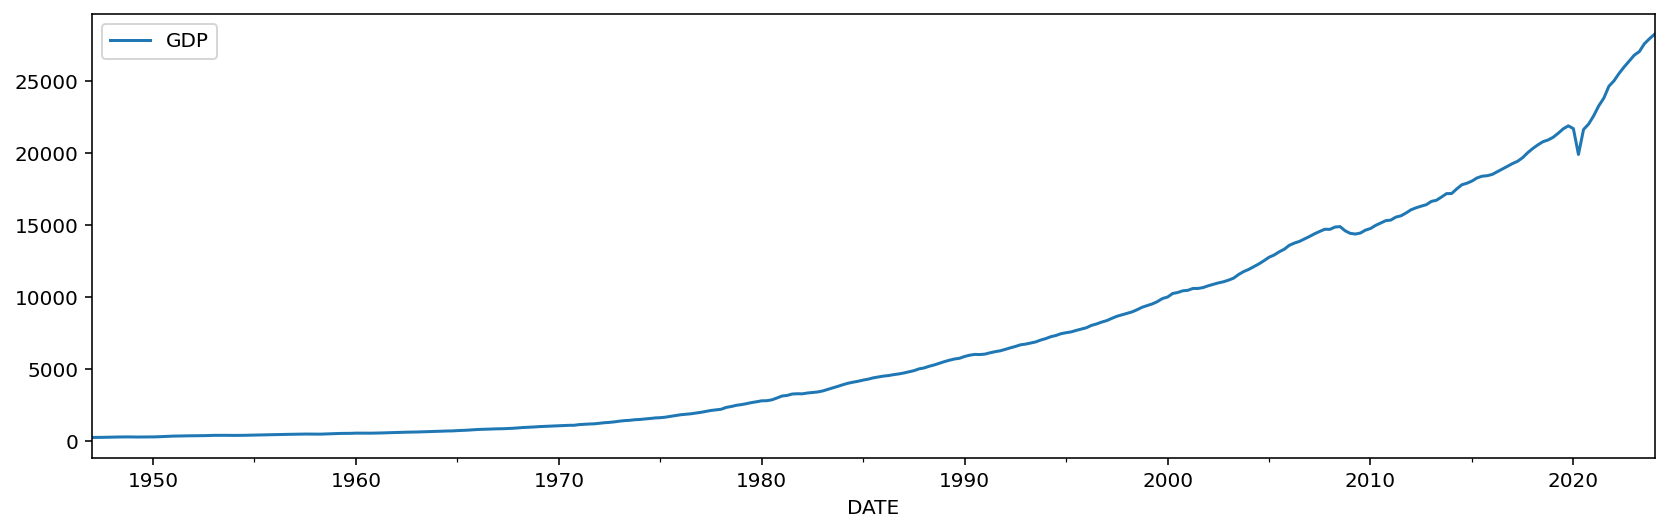

In [7]:
fig, ax = plt.subplots(figsize=(14,4), dpi=144)
gdp.plot(ax=ax)
plt.show()

In [8]:
# Local Linear Trend component
trend_states = ['level', 'trend']
sigma_trend = 1e-4
T_trend = np.array([[1.0, 1.0],
                    [0.0, 1.0]])
Q_trend = np.array([[sigma_trend ** 2]])
R_trend = np.array([[0.0],
                    [1.0]])
Z_trend = np.array([[1.0, 0.0]])

# Seasonal component -- try an 8 year business cycle
T_season = np.eye(8, k=-1)
T_season[0] = -1

R_season = np.zeros((8, 0))
Z_season = np.zeros((1, 8))
Z_season[0,0] = 1

# Correlated noise component
rho = 0.95
sigma_AR = 1e-4
T_AR = np.array([[rho]])
Q_AR = np.array([[sigma_AR ** 2]])
R_AR = np.array([[1.0]])
Z_AR = np.array([[1.0]])

from scipy import linalg
T = linalg.block_diag(T_trend, T_season, T_AR)
R = linalg.block_diag(R_trend, R_season, R_AR)
Q = linalg.block_diag(Q_trend, Q_AR)
Z = np.concatenate([Z_trend, Z_season, Z_AR], axis=-1)

H = np.array([[0.0]])

In [9]:
def run_kalman_filter(data, T, Z, R, H, Q):
    n_timesteps = data.shape[0]
    n_states = T.shape[0]
    
    initial_state = np.random.normal(loc=0, scale=1, size=n_states)
    inital_state_cov = np.eye(n_states)

    hidden_states = np.empty((data.shape[0] + 1, n_states))
    hidden_state_cov = np.empty((data.shape[0] + 1, n_states, n_states))
    hidden_states[0] = initial_state
    hidden_state_cov[0] = inital_state_cov
    
    for t in range(1, n_timesteps):
        observation = data[t]
        mu_filtered, Sigma_filtered = kalman_update(hidden_states[t-1], hidden_state_cov[t-1], observation, T, Z, R, H, Q)
        next_mu, next_sigma = kalman_predictions(mu_filtered, Sigma_filtered, T, Z, R, Q)
        hidden_states[t] = next_mu
        hidden_state_cov[t] = next_sigma
    
    return hidden_states, hidden_state_cov

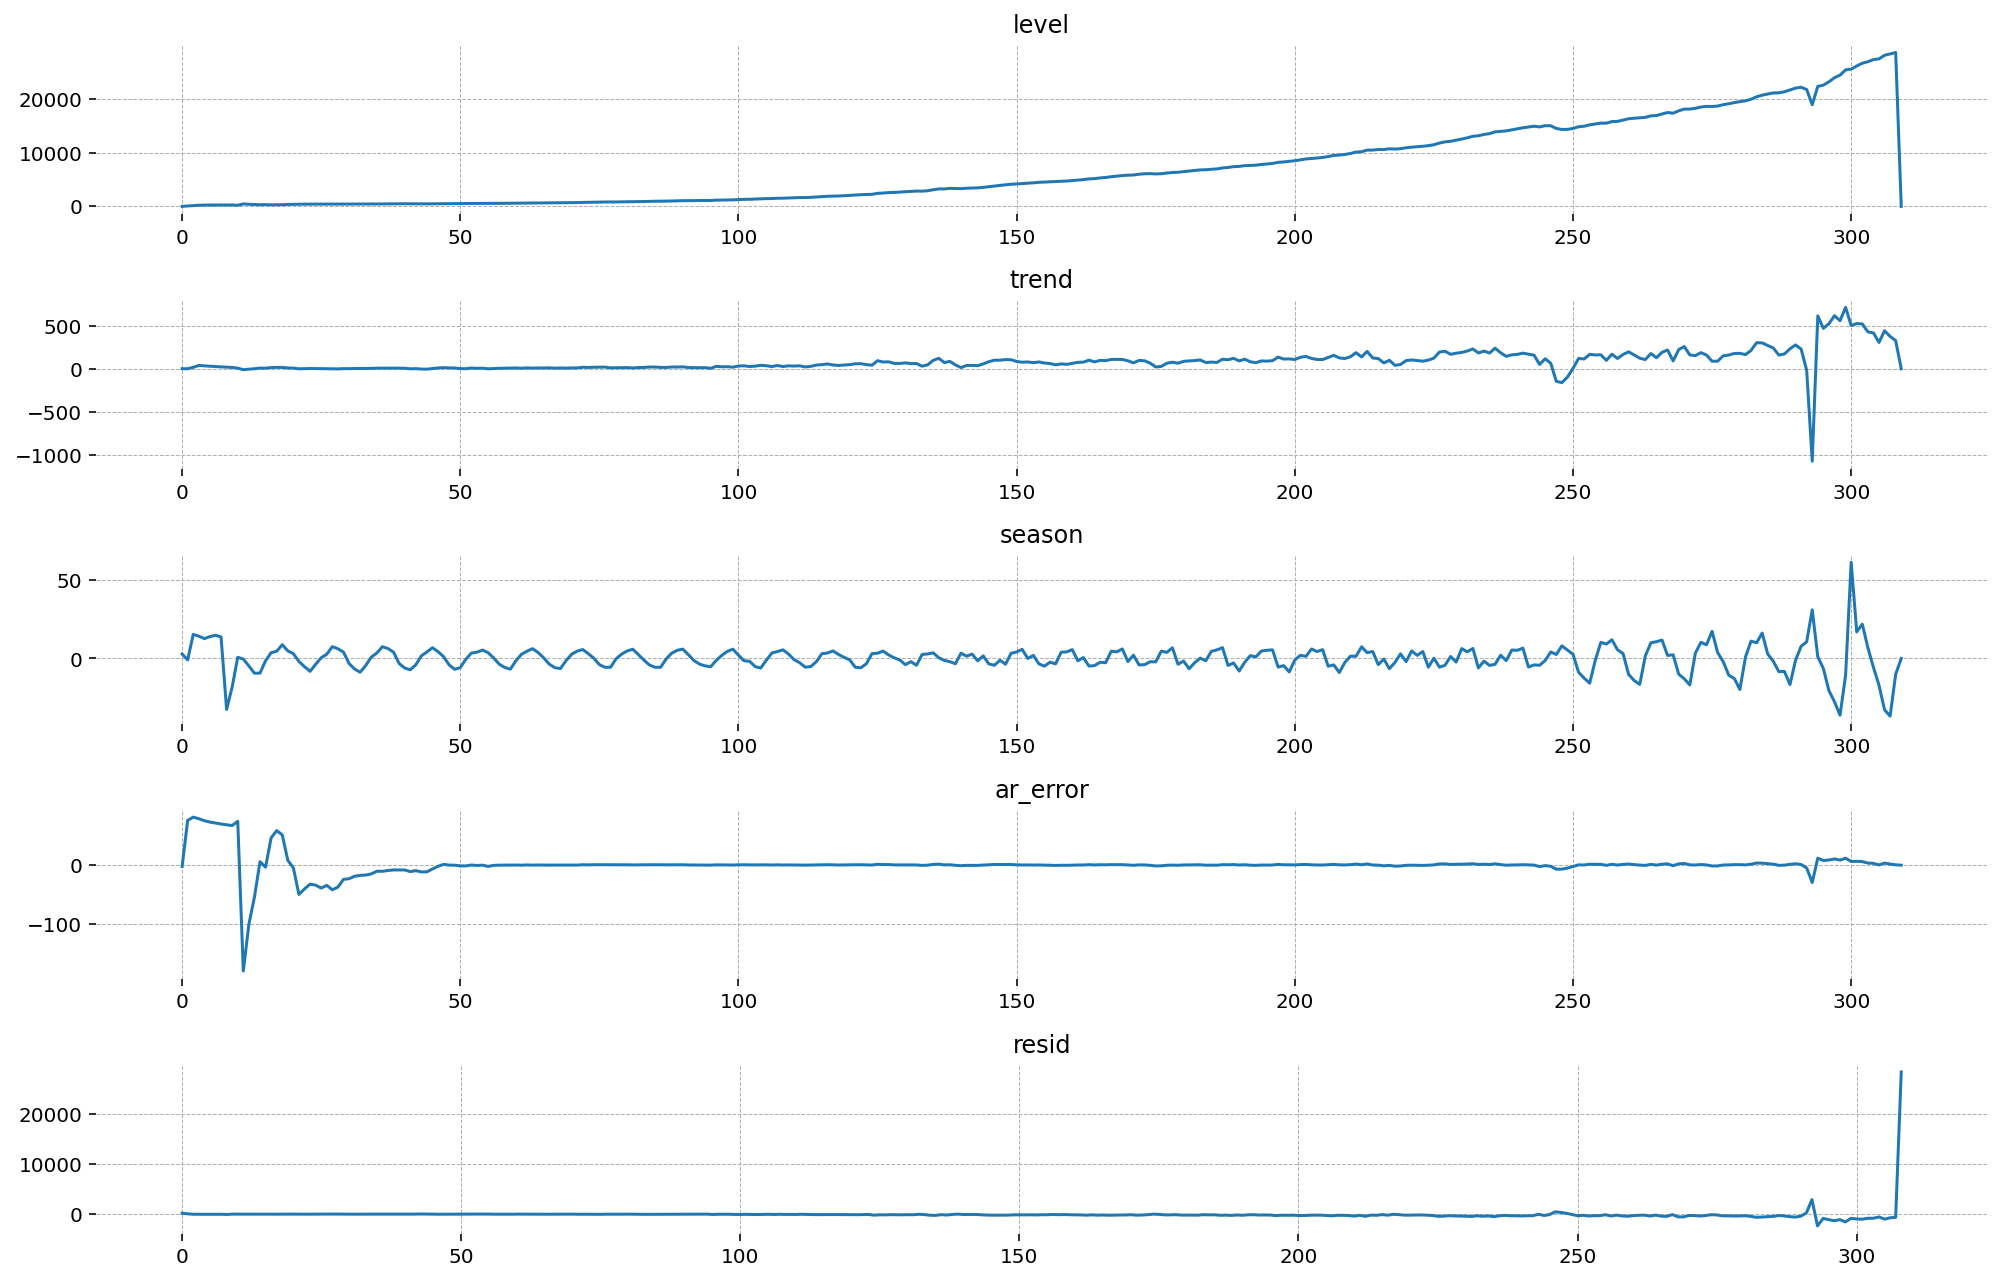

In [10]:
hidden_states, hidden_state_cov = run_kalman_filter(gdp.values, T, Z, R, H, Q)

level = hidden_states[:, 0, None]
trend = hidden_states[:, 1, None]
season = hidden_states[:, 2:-1]
ar_error = hidden_states[:, -1, None]
resid = gdp.values - np.einsum('os,ts->to', Z, hidden_states)[1:]

fig, ax = plt.subplots(5, 1, figsize=(14, 9), dpi=144)

for name, series, axis in zip(['level', 'trend', 'season', 'ar_error', 'resid'], 
                              [level, trend, season, ar_error, resid], fig.axes):
    axis.plot(series.sum(axis=-1))
    axis.set(title=name)
    axis.grid(ls='--', lw=0.5)
    [spine.set_visible(False) for spine in axis.spines.values()]
fig.tight_layout()
plt.show()

In [11]:
time_kalman_py = %timeit -o run_kalman_filter(gdp.values, T, Z, R, H, Q)

# JIT all functions

kalman_predictions = nb.njit(kalman_predictions)
kalman_update = nb.njit(kalman_update)
nb_run_kalman_filter = nb.njit(run_kalman_filter)

# Run once to trigger compilation
nb_run_kalman_filter(gdp.values, T, Z, R, H, Q)
time_kalman_nb = %timeit -o nb_run_kalman_filter(gdp.values, T, Z, R, H, Q)

print(f'numba speedup vs numpy: {time_kalman_py.average / time_kalman_nb.average: 0.2f}x')

5.44 ms ± 86 μs per loop (mean ± std. dev. of 7 runs, 100 loops each)
1.1 ms ± 11.6 μs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)
numba speedup vs numpy:  4.93x


# Take Aways

- Compared to basic python code, JIT compiling offers huge speedups
- When dealing with loops, JIT still offers a speedup compared to pre-compiled packages
- ...but be wary of optimizing too soon!